In [171]:
import numpy                as np
import matplotlib.pyplot    as plt

from rakifov_wake   import RafikovWake
from plots          import spiral_v_contours_plot
from rotations      import rotation_matrix
from copy           import deepcopy

In [172]:
# parameters not fit for
distance    = 101.5
inclination = -225
pos_angle   = 45

In [173]:
arr = np.load('tapered_surface.npy')

def tapered_powerlaw(r, z0, q, r_taper=np.inf, q_taper=1.0, r_cavity=0.0,
                    r0=1.0):
    """Exponentially tapered power law profile."""
    rr = np.clip(r - r_cavity, a_min=0.0, a_max=None)
    f = powerlaw(rr, z0, q, r_cavity=0.0, r0=r0)
    return f * np.exp(-(rr / r_taper)**q_taper)

def powerlaw(r, z0, q, r_cavity=0.0, r0=1.0):
    """Standard power law profile."""
    rr = np.clip(r - r_cavity, a_min=0.0, a_max=None)
    return z0 * (rr / r0)**q

def height(r):
    return tapered_powerlaw(r, arr[0], arr[1], r_taper=arr[2], q_taper=arr[3], r_cavity=0.0,
                        r0=1.0)

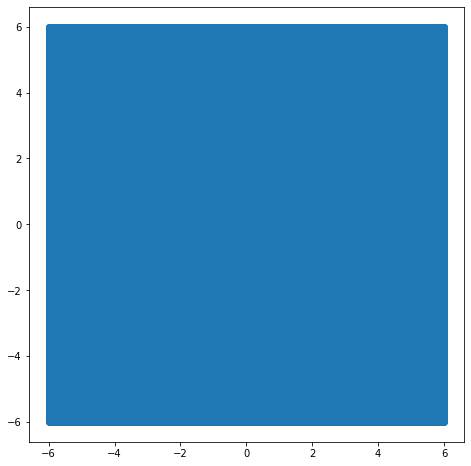

In [174]:
# setup even points in x, y

lim = 6
n_points = 500

x_points = np.linspace(-lim, lim, n_points)
y_points = np.linspace(-lim, lim, n_points)
x_points, y_points = np.meshgrid(x_points, y_points)

plt.figure(figsize=[8,8])
plt.scatter(x_points, y_points)
plt.axis('scaled')
plt.show()

In [175]:
# apply heights and plot in 3D

r_points = np.sqrt(x_points**2 + y_points**2)
z_points = height(r_points)

fig = plt.figure(figsize=[7,7], dpi=100)
ax = plt.axes(projection='3d')

# Plot
ax.scatter(x_points, y_points, z_points, lw=0.5)

# Labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-lim,lim)

plt.show()

In [ ]:
# rotate to desired angles

# get original points for later
x_points_mid = deepcopy(x_points)
y_points_mid = deepcopy(y_points)
z_points_mid = deepcopy(z_points)

# rotation matrices
rot_in_x = rotation_matrix(inclination*np.pi/180, "x")
rot_pa_z = rotation_matrix(  pos_angle*np.pi/180, "z")

# loop over all points
for i in range(x_points.shape[0]):
    for j in range(x_points.shape[1]):
        
        x_points[i,j], y_points[i,j], z_points[i,j] = np.dot(rot_in_x, [x_points[i,j], y_points[i,j], z_points[i,j]])
        x_points[i,j], y_points[i,j], z_points[i,j] = np.dot(rot_pa_z, [x_points[i,j], y_points[i,j], z_points[i,j]])

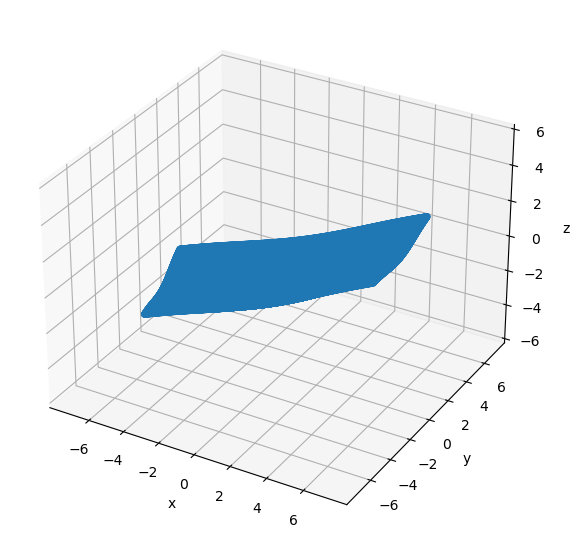

In [ ]:
fig = plt.figure(figsize=[7,7], dpi=100)
ax = plt.axes(projection='3d')

# Plot
ax.scatter(x_points, y_points, z_points, lw=0.5)

# Labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-lim,lim)

plt.show()

In [ ]:
# lets pick some parameters (that will be fit)
hr      = 0.1
q       = 0.25
Rp      = 200
az_p    = 45

In [ ]:
# make a wake
wake = RafikovWake(hrp=hr, q=q, Rp=Rp, rin=10, rout=600)

# save unrotated wake coordinates
wake0 = deepcopy(wake)
wake.rotate_wake(PA=0, planet_az=-az_p, inc=0, distance=distance)
wake0.angular_coords(distance=distance)

# rotate wake
wake.rotate_wake(PA=pos_angle, planet_az=az_p, inc=inclination, distance=distance)
wake.angular_coords(distance=distance)

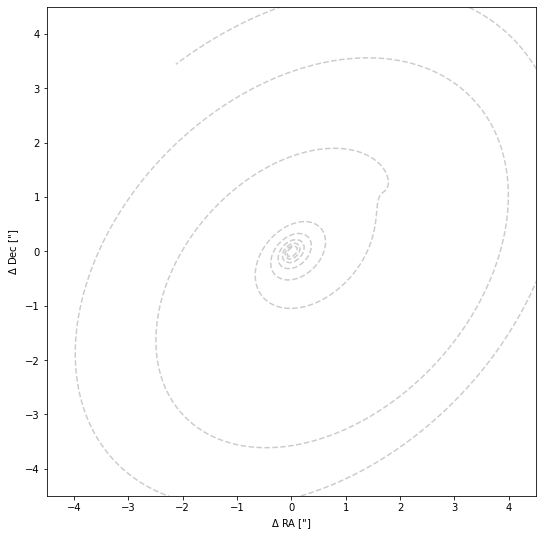

In [ ]:
# now plot the spiral as it is observed
spiral_v_contours_plot(
    spiral          = None,
    spiral_max      = None,
    spiral_levels   = None,
    contours        = None,
    contour_cmap    = None,
    contour_levels  = None,
    lim             = 4.5,
    show            = True,
    rafikov_wake    = wake,
    gap             = False,
    save            = None
)

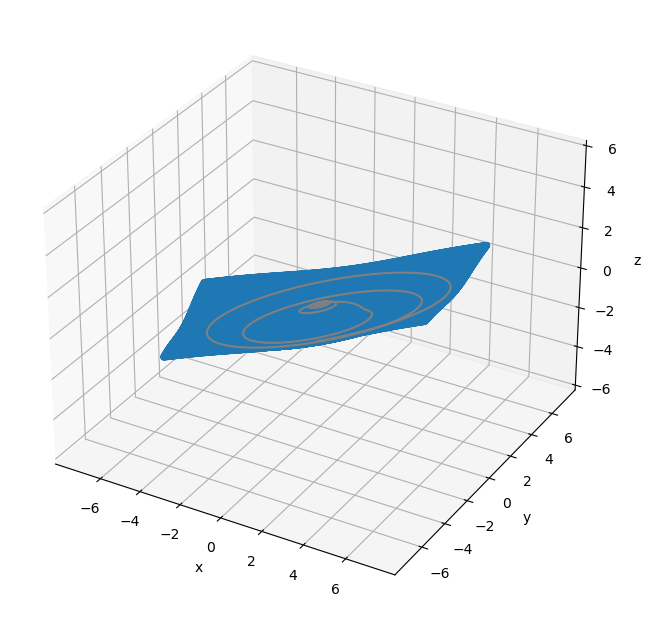

In [ ]:
# plot the wake in 3D on top of our surface grid to check we did it correctly

# apply heights and plot in 3D
fig = plt.figure(figsize=[8,8], dpi=100)
ax = plt.axes(projection='3d')

# Plot our orbit
ax.scatter(x_points, y_points, z_points, lw=0.5, zorder=0)
ax.plot3D(wake.X, wake.Y, wake.Z, c='grey', zorder=3)

# Labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-lim,lim)

plt.show()

In [ ]:
# will deproject the points on the grey line, using the blue dots

new_wake_x = np.zeros(wake.X.shape[0])
new_wake_y = np.zeros(wake.Y.shape[0])

# for points along the grey line
for i in range(wake.X.shape[0]):
    
    # get distances from each 'grid' point
    distance_from_blue = np.sqrt((x_points - wake.X[i])**2 + (y_points - wake.Y[i])**2)
    
    # find closest point
    minimum = 1e9
    ind1 = None
    ind2 = None

    for j in range(distance_from_blue.shape[0]):
        for k in range(distance_from_blue.shape[1]):
            
            if distance_from_blue[j,k] < minimum:
                minimum = distance_from_blue[j,k]
                ind1, ind2 = j, k
    
    new_wake_x[i], new_wake_y[i] = x_points_mid[ind1,ind2], y_points_mid[ind1,ind2]

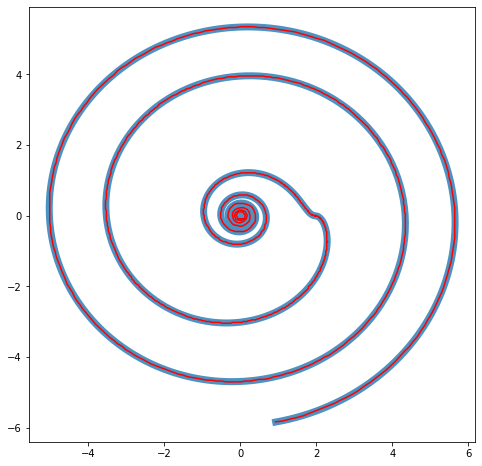

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(wake0.X,wake0.Y, linewidth=7, alpha=0.8)
plt.plot(new_wake_x, new_wake_y, color='red')
plt.show()

In [ ]:
from deproject import deproject_points

(-5.546693386773548, 6.171943887775551, -6.390781563126253, 5.909819639278558)

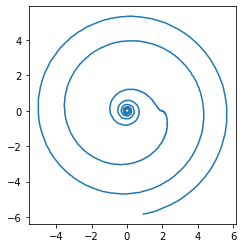

In [ ]:
inclination = -225
pos_angle   = 45

x_points = wake.X
y_points = wake.Y

deproj_x, deproj_y = deproject_points(inclination=inclination, 
                 pos_angle=pos_angle, 
                 x_points=x_points, 
                 y_points=y_points,
                 resolution=500
)

plt.plot(deproj_x, deproj_y)
plt.axis('scaled')